In [1]:
# imports
import networkx as nx
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, text
import time
from IPython.display import clear_output
import re

### Insert code here for importing the dataset

### Helper Methods

In [2]:
# main method used to igniting the forest
def ignite():
	burning_nodes = remove_inactive([n for n in g.nodes])
	for ignition_node in burning_nodes:
		neighbors = [n for n in g.neighbors(ignition_node)]
		if (len(neighbors) == 0):
			break
		for nb in neighbors:
			g.nodes[nb]['num_of_active_neighbors'] += 1
			active_nb = remove_inactive([n for n in g.neighbors(nb)])

			s = 0
			for burning_nb in active_nb:
				w = g.get_edge_data(burning_nb, nb)['w']
				s = min(1,s+w)

			ths = g.nodes[nb]['threshold_switch']
			if (s > ths):
				g.nodes[ignition_node]['num_of_active_neighbors'] += 1
				g.nodes[nb]['fire_state'] = 'burning'
				colors[nb-1] = 'orange'
				g[ignition_node][nb]['color'] = 'orange'

# count how many are burning currently in the map
def count_burning(g):
	burning = 0
	for i in range(1,g.number_of_nodes()+1):
		if (g.nodes[i]['fire_state'] == 'burning'):
			burning += 1
	return burning

# function used to draw the graph according to some parameters
def draw_graph(g, ns, node_colors, edge_colors, pos_dict, fs):
	nx.draw(g, node_size=ns, node_color=node_colors, edge_color=edge_colors, with_labels=wl, pos=pos_dict, font_size=fs)
	pos=nx.get_node_attributes(g,'pos')

# methods for updating life
def life_edge_update():
	for p in range(1,g.number_of_nodes()+1):
		for q in range(i,g.number_of_nodes()+1):
			if (p == q):
				continue
			if ((p,q) not in [e for e in g.edges()]):
				continue
			if (g[p][q]['color'] == 'orange'):
				g[p][q]['life'] -= 1
			if (g[p][q]['life'] <= 0):
				g[p][q]['color'] == 'brown'
				
def lifeline_update():
	for node in [n for n in g.nodes()]:
		if (g.nodes[node]['fire_state'] == 'burning'):
			g.nodes[node]['life'] -= 1
		if (g.nodes[node]['life'] <= 0):
			colors[node-1] = 'brown'

# given a list of nodes, return those nodes that are burning
def remove_inactive(lst):
	u = [node for node in lst if g.nodes[node]['fire_state'] == 'burning']
	return u

# compute euclidean distance (np might have it already?)
def dist(pair1, pair2):
	x1 = pair1[0]
	y1 = pair1[1]
	x2 = pair2[0]
	y2 = pair2[1]
	return pow(pow((x2-x1),2) + pow((y2-y1),2),1/2)

### Main Method

Timestep  9 :


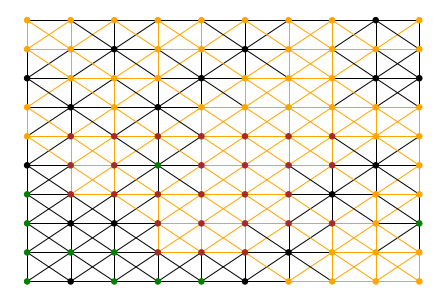

Forest fire simulation complete.


In [4]:
# parameters to play around
nodes = 100 # number of nodes in the network
scale = 100/nodes # scale to fit into visual
delta = 1.42*scale # threshold proximity for the fire
density_factor = 0.8 # network dense factor (what percent of the network will have trees); uniform rnd
wl = False # whether you want to see labels
pos_dict = {} # dictionary that will hold (K,V) pairs of (node, pos)

g = nx.Graph() # create graph
k = 1 # node name
empty_list = [] # list of nodes that do not have trees
for i in range(1,int(np.sqrt(nodes))+1):
	for j in range(1,int(np.sqrt(nodes))+1):
		theta = round(rnd.uniform(0,1),2) # random threshold of node
		if (rnd.uniform(0,1) > density_factor):
			g.add_node(k, threshold_switch = 1.0, num_of_active_neighbors = 0, fire_state = 'empty', life = 5, pos=(i*scale,j*scale))
			empty_list.append(k)
		else:
			g.add_node(k, threshold_switch = theta, num_of_active_neighbors = 0, fire_state = 'not_burnt', life = 5, pos=(i*scale,j*scale))
		pos_dict[k] = (i,j)
		k += 1

edge_list = [] # contains edge list
for i in range(1,nodes+1):
	for j in range(i,nodes+1):
		if (i == j):
			continue
		p1 = g.nodes[i]['pos']
		p2 = g.nodes[j]['pos']
		# the euclidean distance checks for whether an edge should exist, faraway nodes don't have edges
		if (dist(p1,p2) < delta): 
			edge_list.append((i,j))

# add edges to the network
for edge in edge_list:
	n1 = edge[0]
	n2 = edge[1]
	p12 = round(rnd.uniform(0,1),2)
	g.add_edge(n1, n2, w=p12, color='black', life=5)
	
edge_colors = nx.get_edge_attributes(g,'color').values()

colors=['green' for i in range(nodes)]
# nodes which don't have trees are colored black
for item in empty_list:
	colors[item-1] = 'black'

# ========================== Simulations happen below
print("Timestep  0:")
nx.draw(g, node_size=30, node_color=colors, edge_color=edge_colors, with_labels=wl, pos=pos_dict, font_size=15)
pos=nx.get_node_attributes(g,'pos')
plt.show()
time.sleep(1)
clear_output(wait=True)

num = g.number_of_nodes()
ignition_node = rnd.randint(1,num+1)
g.nodes[ignition_node]['fire_state'] = 'burning'
colors[ignition_node-1] = 'orange'

timesteps = 20
prev_burning_forests = 0
current_burning_forests = 1
i = 1

while (i <= timesteps and prev_burning_forests < current_burning_forests):
	print("Timestep ", i, ":")
	edge_colors = nx.get_edge_attributes(g,'color').values()
	draw_graph(g, 30, colors, edge_colors, pos_dict, 20)
	plt.show()
	ignite()
	lifeline_update()
	life_edge_update()
	prev_burning_forests = current_burning_forests
	current_burning_forests = count_burning(g)
	if (i == timesteps or prev_burning_forests >= current_burning_forests):
		break
	time.sleep(2)
	clear_output(wait=True)
	i += 1

print("Forest fire simulation complete.")